# ICML 2018 Toy Experiment


In [61]:
# Setup parameters for experiment
data_name = 'sin_wave'
n_train = 10000
cv = 3  # Number of cv splits
random_state = 0

import multiprocessing
n_jobs = multiprocessing.cpu_count()
print('n_jobs=%d' % n_jobs)

n_jobs=56


In [62]:
# Imports and basic setup of logging and seaborn
%load_ext autoreload
%autoreload 2
# from __future__ import division
# from __future__ import print_function
import sys, os, logging
import pickle
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import clone
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

sys.path.append('..')  # Enable importing from package ddl without installing ddl
from ddl.base import CompositeDestructor
from ddl.datasets import make_toy_data
from ddl.deep import DeepDestructorCV, DeepDestructor
from ddl.independent import IndependentDestructor, IndependentDensity, IndependentInverseCdf
from ddl.univariate import ScipyUnivariateDensity, HistogramUnivariateDensity
from ddl.linear import (LinearProjector, RandomOrthogonalEstimator, 
                        BestLinearReconstructionDestructor)
from ddl.autoregressive import AutoregressiveDestructor
from ddl.mixture import GaussianMixtureDensity, FirstFixedGaussianMixtureDensity
from ddl.tree import TreeDestructor, TreeDensity, RandomTreeEstimator
from ddl.externals.mlpack import MlpackDensityTreeEstimator

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings('ignore', category=DataConversionWarning)

# Setup seaborn
try:
    import seaborn as sns
except ImportError:
    print('Could not import seaborn so colors may be different') 
else:
    sns.set()
    sns.despine()

# Setup logging
logging.basicConfig(stream=sys.stdout)
#logging.captureWarnings(True)
logging.getLogger('ddl').setLevel(logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [63]:
# LINEAR DESTRUCTORS
alpha_histogram = [1, 10, 100]
random_linear_projector = LinearProjector(
    linear_estimator=RandomOrthogonalEstimator(), orthogonal=True
)
canonical_histogram_destructors = [
    IndependentDestructor(
        independent_density=IndependentDensity(
            univariate_estimators=HistogramUnivariateDensity(bins=20, bounds=[0, 1], alpha=a)
        )
    )
    for a in alpha_histogram
]
linear_destructors = [
    DeepDestructorCV(
        init_destructor=IndependentDestructor(),
        canonical_destructor=CompositeDestructor(destructors=[
            IndependentInverseCdf(),  # Project to inf real space
            random_linear_projector,  # Random linear projector
            IndependentDestructor(),  # Project to canonical space
            destructor,  # Histogram destructor in canonical space
        ]),
        n_extend=20,  # Need to extend since random projections
    )
    for destructor in canonical_histogram_destructors
]
linear_names = ['RandLin (%g)' % a for a in alpha_histogram]

In [64]:
# layers = [1, 10, 50]
# random_state = 123

# rbig_destructors = [
#     DeepDestructor(
#         canonical_destructor=CompositeDestructor(
#             [
#                 IndependentDestructor(
#                     IndependentDensity(
#                         univariate_estimators=HistogramUnivariateDensity(
#                             bounds=0.01, bins='auto', alpha=1e-3
#                     )
#                 )),
#                 IndependentInverseCdf(),
#                 LinearProjector(linear_estimator=PCA())
#              ]
#         ), random_state=random_state, 
#         n_canonical_destructors=ilayer
#     ) for ilayer in layers
# ]

# rbig_names = [f"rbig_{ilayer}" for ilayer in layers]

In [65]:
# Make dataset and create train/test splits
n_samples = 2 * n_train
D = make_toy_data(data_name, n_samples=n_samples, random_state=random_state)
X_train = D.X[:n_train]
y_train = D.y[:n_train] if D.y is not None else None
X_test = D.X[n_train:]
y_test = D.y[n_train:] if D.y is not None else None

def _fit_and_score(data_name, destructor, destructor_name, n_train, random_state=0):
    """Simple function to fit and score a destructor."""
    # Fix random state of global generator so repeatable if destructors are random
    rng = check_random_state(random_state)
    old_random_state = np.random.get_state()
    np.random.seed(rng.randint(2 ** 32, dtype=np.uint32))
    
    try:
        # Fit destructor
        start_time = time.time()
        destructor.fit(X_train)
        train_time = time.time() - start_time
    except RuntimeError as e:
        # Handle MLPACK error
        if 'mlpack' not in str(e).lower():
            raise e
        warnings.warn('Skipping density tree destructors because of MLPACK error "%s". '
                      'Using dummy IndependentDestructor() instead.' % str(e))
        destructor = CompositeDestructor([IndependentDestructor()]).fit(X_train)
        train_time = 0
        train_score = -np.inf
        test_score = -np.inf
        score_time = 0 
    else:
        # Get scores
        start_time = time.time()
        train_score = destructor.score(X_train)
        test_score = destructor.score(X_test)
        score_time = time.time() - start_time
        
    logger.debug('train=%.3f, test=%.3f, train_time=%.3f, score_time=%.3f, destructor=%s, data_name=%s' 
                 % (train_score, test_score, train_time, score_time, destructor_name, data_name))

    # Reset random state
    np.random.set_state(old_random_state)
    return dict(fitted_destructor=destructor,
                destructor_name=destructor_name,
                train_score=train_score,
                test_score=test_score)

In [51]:

U = np.random.uniform(0.0, 1.0, (1000, 2))
D_ori = linear_destructors[-1].inverse_transform(U)

In [66]:
# Collect all destructors and set CV parameter
destructors = linear_destructors  #+ mixture_destructors # + tree_destructors
destructor_names = linear_names #+ mixture_names  #+ tree_names
for d in destructors:
    if 'cv' in d.get_params():
        d.set_params(cv=cv)
        
# Fit and score destructor
results_arr = Parallel(n_jobs=1)(
    delayed(_fit_and_score)(
        data_name, destructor, destructor_name, n_train, random_state=random_state,
    )
    for di, (destructor, destructor_name) in enumerate(zip(destructors, destructor_names))
)

DEBUG:__main__:train=-1.693, test=-1.789, train_time=13.298, score_time=2.930, destructor=RandLin (1), data_name=sin_wave
DEBUG:__main__:train=-1.686, test=-1.766, train_time=12.452, score_time=2.706, destructor=RandLin (10), data_name=sin_wave
DEBUG:__main__:train=-1.670, test=-1.757, train_time=14.536, score_time=3.158, destructor=RandLin (100), data_name=sin_wave


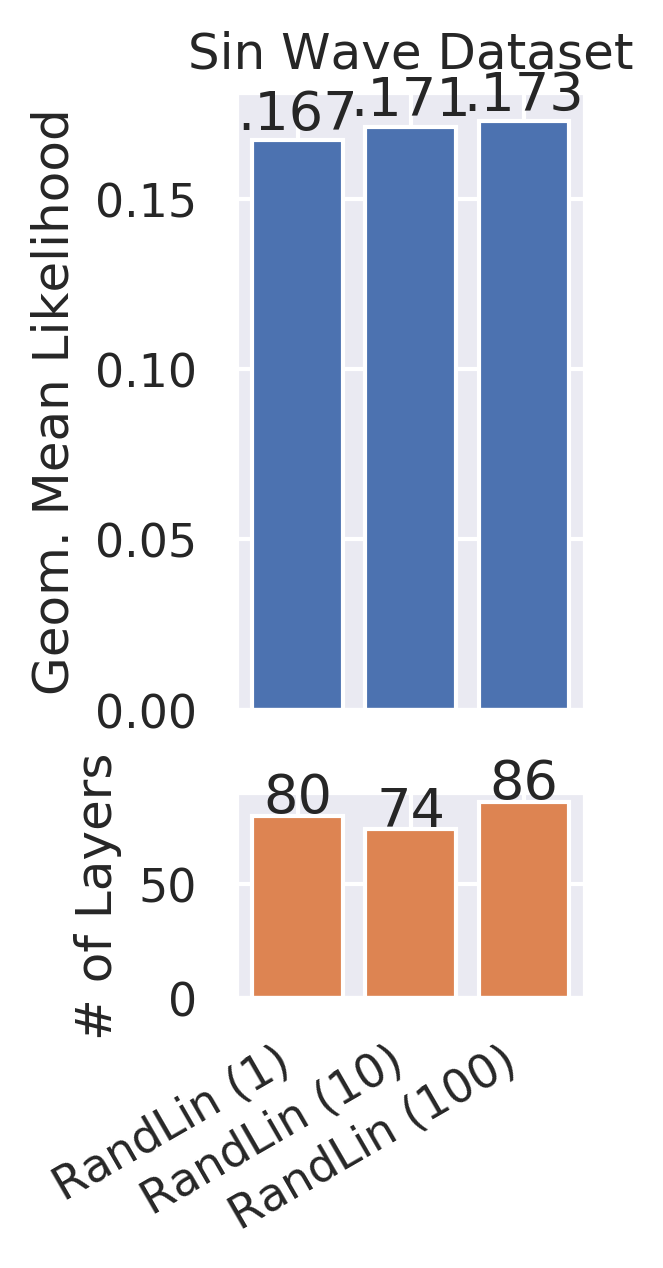

In [67]:
# Compile results for plotting
def _add_val_over_bar(ax, vals, fmt='%.3f'):
    """Add value text over matplotlib bar chart."""
    for v, p in zip(vals, ax.patches):
        height = p.get_height()
        val_str = fmt % v
        if '0.' in val_str:
            val_str = val_str[1:] 
        ax.text(p.get_x() + p.get_width() / 2.0, height + p.get_height() * 0.02,
                val_str, ha='center', fontsize=13)
        
# Get scores, number of layers and destructor names
exp_test_scores = np.exp([res['test_score'] for res in results_arr])
n_layers=np.array([
    res['fitted_destructor'].best_n_layers_ 
    if hasattr(res['fitted_destructor'], 'best_n_layers_') else 1
    for res in results_arr
])
labels = destructor_names
x_bar = np.arange(len(labels))

# Show result plot
figsize = 8 * np.array([1, 1]) * np.array([len(labels) / 16.0, 0.5])
fig, axes = plt.subplots(2, 1, figsize=figsize, dpi=300, sharex='col', 
                         gridspec_kw=dict(height_ratios=[3, 1]))
axes[0].bar(x_bar, exp_test_scores, color=sns.color_palette()[0])
axes[0].set_ylabel('Geom. Mean Likelihood')
axes[0].set_title('%s Dataset' % data_name.replace('_', ' ').title())
_add_val_over_bar(axes[0], exp_test_scores)
axes[1].bar(x_bar, n_layers, color=sns.color_palette()[1])
axes[1].set_ylabel('# of Layers')
_add_val_over_bar(axes[1], n_layers, fmt='%d')

# Rotate tick labels
plt.xticks(x_bar, ['%s' % l for l in labels])
for item in plt.gca().get_xticklabels():
    item.set_rotation(30)
    item.set_horizontalalignment('right')

# Uncomment below to save png images into notebook folder
#plt.savefig('bar_%s.png' % D.name, bbox_inches='tight')
plt.show()

In [18]:
# Select best destructors of main groups (linear, mixture, tree) and precompute transforms for figure below
selected_arr = [
    res for res in results_arr if res['destructor_name'] in [
        'RandLin (100)', 'GausMix (0.5)', 'RandTree (100)', 'DensityTree (0.9)'
    ]
]
def _add_transform(res):
    res['Z_train'] = res['fitted_destructor'].transform(X_train)
    res['Z_test'] = res['fitted_destructor'].transform(X_test)
    return res
selected_arr = [_add_transform(res) for res in selected_arr] 

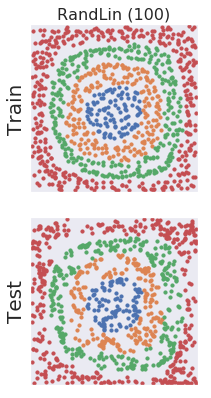

In [19]:
# Create figure for destroyed samples (train and test)
def _clean_axis(ax, limits=None):
    if limits is not None:
        for i, lim in enumerate(limits):
            eps = 0.01 * (lim[1] - lim[0])
            lim = [lim[0] - eps, lim[1] + eps]
            if i == 0:
                ax.set_xlim(lim)
            else:
                ax.set_ylim(lim)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    
def _scatter_X_y(X, y, ax, **kwargs):
    if 's' not in kwargs:
        kwargs['s'] = 18
    if y is not None:
        for label in np.unique(y):
            ax.scatter(X[y == label, 0], X[y == label, 1], **kwargs)
    else:
        ax.scatter(X[:, 0], X[:, 1])
        
fig, axes_mat = plt.subplots(2, len(selected_arr), figsize=(11, 5.7))
axes_mat = axes_mat.reshape(2, -1).transpose()
for i, (res, axes) in enumerate(zip(selected_arr, axes_mat)):
    for split, X_split, y_split,  ax in zip(
        ['Train', 'Test'], [X_train, X_test], [y_train, y_test], axes
    ):
        _scatter_X_y(res['Z_%s' % split.lower()], y_split, ax, s=10)
        _clean_axis(ax, limits=[[0, 1], [0, 1]])
        if split == 'Train':
            ax.set_title(res['destructor_name'], fontsize=16)
        if i == 0:
            ax.set_ylabel(split, fontsize=20)
plt.tight_layout()
plt.show()

../ddl/univariate.py:532: BoundaryWarning: Input to random variable function has at least one value outside of bounds but all input should be in (bounds[0], bounds[1]) exclusive. Bounding values away from bounds[0] or bounds[1]
  'Input to random variable function has at least one value outside of bounds '
../ddl/univariate.py:532: BoundaryWarning: Input to random variable function has at least one value outside of bounds but all input should be in (bounds[0], bounds[1]) exclusive. Bounding values away from bounds[0] or bounds[1]
  'Input to random variable function has at least one value outside of bounds '
../ddl/univariate.py:532: BoundaryWarning: Input to random variable function has at least one value outside of bounds but all input should be in (bounds[0], bounds[1]) exclusive. Bounding values away from bounds[0] or bounds[1]
  'Input to random variable function has at least one value outside of bounds '
../ddl/univariate.py:532: BoundaryWarning: Input to random variable function

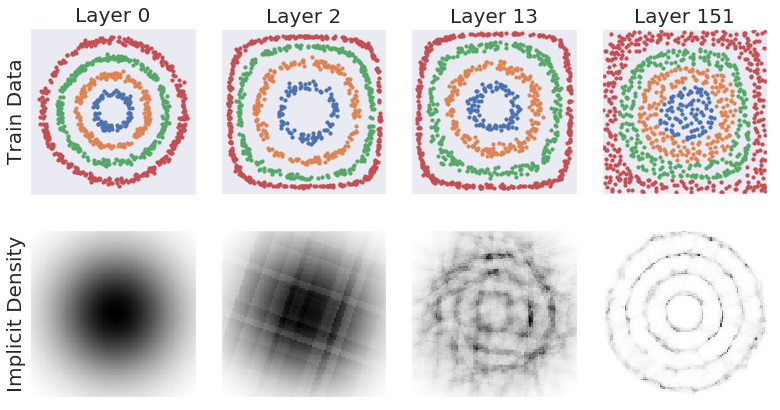

In [21]:
# Create figure to show progression across stages
selected_res = next(res for res in results_arr if res['destructor_name'] == 'RandLin (100)')
selected_destructor = selected_res['fitted_destructor']
n_layers = len(selected_destructor.fitted_destructors_)
disp_layers = np.minimum(n_layers - 1, np.logspace(0, np.log10(n_layers - 1), 3, endpoint=True, dtype=np.int))
disp_layers = np.concatenate(([0], disp_layers))

fig, axes = plt.subplots(2, len(disp_layers), figsize=np.array([11, 6]))
axes = axes.transpose()
for li, axes_col in zip(disp_layers, axes):
    partial_idx = np.arange(li + 1)
    if li == 0:
        # Special case to show original raw data
        Z_partial_train = X_train
        title = 'Layer 0'
        axes_col[0].set_ylabel('Train Data', fontsize=20)
        axes_col[1].set_ylabel('Implicit Density', fontsize=20)
    else:
        Z_partial_train = selected_destructor.transform(X_train, partial_idx=partial_idx)
        title = 'Layer %d' % (li + 1)
    
    # Create grid of points (extend slightly beyond min and maximum of data)
    n_query = 100
    perc_extend = 0.02
    bounds = np.array([np.min(D.X, axis=0), np.max(D.X, axis=0)]).transpose()
    bounds_diff = bounds[:, 1] - bounds[:, 0]
    bounds[:, 0] -= perc_extend / 2 * bounds_diff
    bounds[:, 1] += perc_extend / 2 * bounds_diff
    x_q = np.linspace(*bounds[0, :], num=n_query)
    y_q = np.linspace(*bounds[1, :], num=n_query)
    X_grid, Y_grid = np.meshgrid(x_q, y_q)
    X_query = np.array([X_grid.ravel(), Y_grid.ravel()]).transpose()
    
    # Get density values along grid
    log_pdf_grid = selected_destructor.score_samples(
        X_query, partial_idx=partial_idx).reshape(n_query, -1)
    pdf_grid = np.exp(np.maximum(log_pdf_grid, -16))
    
    # Show scatter plot
    _scatter_X_y(Z_partial_train, y_train, axes_col[0], s=10)
    _clean_axis(axes_col[0], limits=[[0, 1], [0, 1]] if li > 0 else None)
    axes_col[0].set_title(title, fontsize=20)
    
    # Show density
    axes_col[1].pcolormesh(X_grid, Y_grid, -pdf_grid, cmap='gray', zorder=-1)
    _clean_axis(axes_col[1])
    
plt.tight_layout()
plt.show()